In [ ]:
# Loading datasets and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from numpy import random
#from google.colab import files

!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler # , SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### NO NEED IF USING X_smote, y_smote
#ros = RandomOverSampler(sampling_strategy= {0:72471, 1:4000, 2:8000, 3:1500, 4:8000 })

df = pd.read_csv('drive/MyDrive/Train_set.csv')
df.fillna(0, inplace = True)
ids = df['ID']
y = df['Class']
y = np.array(y)
X = df.drop(['ID', 'Class'], axis=1)
X = np.array(X)


# Linearly expand
def expand_linear(time_series):
  left = 0
  right = 0
  for k in range(1, len(time_series)):
    if time_series[k] == 0:
      left = time_series[k-1]
      l = 0
      while time_series[k+l] == 0:
        l+=1
        if len(time_series) == k+l:
          return time_series
      right = time_series[k+l]
      time_series[k: k+l] = np.linspace(left, right, num=l+2)[1:(l+1)]
  return time_series



  # Scale but no 0s
nonX = X.reshape(-1)
nonX = nonX[nonX!=0]
mean = np.mean(nonX)
std = np.std(nonX)
for r in range(X.shape[0]):
  for c in range(X.shape[1]):
    if X[r,c] != 0:
      X[r,c] -= mean
X = X/std

for k in range(X.shape[0]):
  expand_linear(X[k,:])
# X is the data after preprocessing in a numpy array

In [ ]:
#np.savetxt("beforesmotey",y)
# AFTER SMOTE
y = np.loadtxt("drive/MyDrive/beforesmotey")
X = np.loadtxt("drive/MyDrive/beforesmote")

In [ ]:
# SMOTE doesnt work in colab, maybe splitting or pycharm
#ros = SMOTE(sampling_strategy= {0:72471, 1:4000, 2:8000, 3:1500, 4:8000 })
#X, y = ros.fit_resample(X,y)

NameError: ignored

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_dim,mlp_dim, drop):
   
        super().__init__()
        self.hidden_dim = hidden_dim
        # Attention
        self.attention = nn.MultiheadAttention(embed_dim = hidden_dim, num_heads = 1)
        # LSTM layer
        self.rnn = nn.LSTM(input_size = 1, hidden_size = hidden_dim, num_layers = 1)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, mlp_dim) 
        self.fc2 = nn.Linear(mlp_dim, 5)
        self.logsoftmax = nn.LogSoftmax() 
        self.layer = nn.LayerNorm(hidden_dim)
        # Capa dropout 
        self.dropout = nn.Dropout(p=drop)

    def forward(self, x):

        '''
        - x: Sequences of word embeddings. Dimensions (#no batch, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify
        '''
        #x = x.reshape(x.size(0))
        # Compute the RNN output (sequence of states for the whole input)
        _, last_state_tup =  self.rnn(x)
        last_state = last_state_tup[0]
        x = self.attention(last_state,last_state,last_state)[0]
        #x = self.attention(states[-1,:].view(1,-1),states,states)[0]
        #x = self.attention.forward(states).flatten() before
        #x = self.layer(x)
        x_drop = self.dropout(x)
        x_out = self.fc1(x_drop)
        x_drop = self.dropout(x)
        x_out = self.fc2(x_drop)
        # We classify using such tensor (don't forget the dropout!)
        output = self.logsoftmax(x_out)
        return output

    def forward_test(self, x):

        x = np.trim_zeros(x, 'b')
        x = torch.Tensor(x).view(-1,1)
        x = x.to(torch.float32)
        #x = x.to(self.device)
        _, last_state_tup =  self.rnn(x)
        last_state = last_state_tup[0]
        x = self.attention(last_state,last_state,last_state)[0]
        #x = self.attention(states[-1,:].view(1,-1),states,states)[0]
        #x = self.attention.forward(states).flatten() before
        #x += last_state
        #x = self.layer(x)
        x_out = self.fc1(x)
        x_out = self.fc2(x_out)
        # We classify using such tensor (don't forget the dropout!)
        output = self.logsoftmax(x_out)
        return output

In [ ]:
class RNN_with_train(RNN):
    
    def __init__(self,hidden_dim, mlp_dim, drop=0.5,batch_size=32,lr=0.0001,saved_files='./saved_models/kaggle'):
        
        super().__init__(hidden_dim, mlp_dim, drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        
        self.criterion = nn.NLLLoss(weight = torch.tensor([ 1.25,20 , 10 , 45 ,  10 ]))              
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files

        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #self.to(self.device)
            
        
    def trainloop(self, X, Y, valid = False, X_val= None, Y_val= None,epochs= 40,print_every=1):
        
        self.print_every = print_every
        self.epochs=epochs
        n_batch = int(X.shape[0]/self.batch_size)

        for e in range(int(self.epochs)):

          self.train() # Activate dropout
          # random permutation (optional)
          id_perm = np.random.permutation(np.arange(X.shape[0]))
          for nul in range(n_batch):
            # either one - look up random permutation
            idx = id_perm[nul*self.batch_size:(nul+1)*self.batch_size]
            #idx = random.choice(np.arange(X.shape[0]), self.batch_size) # choose element to train given a label
            labels = torch.Tensor(Y[idx]).type(torch.LongTensor)
            #labels.to(self.device)
            outputs = torch.zeros(self.batch_size,5)
            k = 0
            for b in idx:

              running_loss = 0.
              self.optim.zero_grad() 
              x = X[b,:]
              x = np.trim_zeros(x, 'b')
              x = torch.Tensor(x).view(-1,1)
              x = x.to(torch.float32)
              outputs[k, :] = self.forward(x)
              k += 1
              #print([out, class_number])
            #outputs.to(self.device)
            loss = self.criterion(outputs ,labels)
            running_loss += loss.item()
            loss.backward()
            # Gradient clipping
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
            # SGD steps
            self.optim.step()


          self.loss_during_training.append(running_loss) # no self batch size to better see
          if valid:
            self.eval()

            with torch.no_grad():
              labels = torch.Tensor(Y_val).type(torch.LongTensor)
              #labels = labels.to(self.device)
              outputs = torch.zeros(X_val.shape[0],5)
              for k in range(X_val.shape[0]):
                outputs[k, :] = self.forward_test(X_val[k,:])
              #outputs.to(self.device)
              loss = self.criterion(outputs ,labels)
              running_loss += loss.item()
              self.valid_loss_during_training.append(running_loss) # no self batch size to better see
              val_F1 = multiclass_f1_score(outputs, labels, num_classes=5, average = "macro")
          if(e % self.print_every == 0):
            if valid:
              print(f"Training loss after {e+1} epochs: {self.loss_during_training[-1]}, F1:{val_F1}, valid:{self.valid_loss_during_training[-1]}")
            else:
              print(f"Training loss after {e+1} epochs: {self.loss_during_training[-1]}")
            # We save model parameters  
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e+1)+'.pth')
            #files.download(self.saved_files+'_epoch_'+str(e+1)+'.pth')

In [ ]:
rnn = RNN_with_train(128, lr = 0.0008, batch_size = 64) 
rnn.trainloop(X, y,False, epochs=50, print_every=) # idk how many epochs

<ipython-input-11-440114b5c7a8>:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.logsoftmax(x_out)


In [ ]:
#rnn = RNN_with_train(128, lr = 0.0003, batch_size = 48) 
state_dict = torch.load("/content/kaggle_epoch_15.pth")
rnn.load_state_dict(state_dict)

<All keys matched successfully>

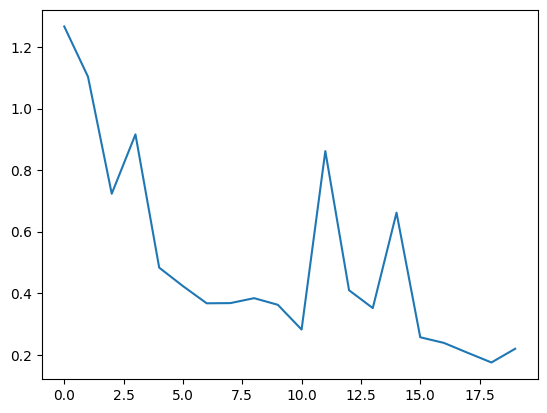

In [ ]:
plt.plot(rnn.valid_loss_during_training)

In [ ]:
df2 = pd.read_csv('drive/MyDrive/Test_set.csv')
df2.fillna(0, inplace = True)
ids = df2['ID']
X_test = df2.drop(['ID'], axis=1)
X_test = np.array(X_test)

  # Scale but no 0s
#nonX_test = X_test.reshape(-1)
#nonX_test = nonX_test[nonX_test!=0]
#mean = np.mean(nonX)
#std = np.std(nonX)
for r in range(X_test.shape[0]):
  for c in range(X_test.shape[1]):
    if X_test[r,c] != 0:
      X_test[r,c] -= mean
X_test = X_test/std

for k in range(X_test.shape[0]):
  expand_linear(X_test[k,:])

# X_test is the data after preprocessing in a numpy array

In [ ]:
pred_classes = [torch.argmax(rnn.forward_test(X_test[k,:])) for k in range(X_test.shape[0])]
pred_classes = np.array(pred_classes)
ids = np.arange(len(pred_classes))
results = pd.DataFrame({'ID': ids, 'Pred_Class': pred_classes})

gabriele = pd.read_csv('sample_submission_deep.csv')
print(sum(gabriele["Pred_Class"] == results["Pred_Class"])) # Best sub

# Save the DataFrame as a CSV file
results.to_csv('epoch25_.csv', index=False)


<ipython-input-11-440114b5c7a8>:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.logsoftmax(x_out)


21366


233

In [ ]:
pred_classes2 = [torch.argmax(rnn.forward_test(X_test[k,:])) for k in range(X_test.shape[0])]
pred_classes2 = np.array(pred_classes2)
ids2 = np.arange(len(pred_classes2))
results2 = pd.DataFrame({'ID': ids, 'Pred_Class': pred_classes2})

<ipython-input-5-440114b5c7a8>:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.logsoftmax(x_out)


In [ ]:
gabriele = pd.read_csv('sample_submission_deep.csv')

ratio_gabriele = gabriele["Pred_Class"].value_counts()
ratio = np.array(pd.Series(y).value_counts()/X.shape[0]*22000)
ratio_est = results["Pred_Class"].value_counts()
df_ratio = pd.DataFrame({"train":ratio, "gabriele":ratio_gabriele, "current": ratio_est})

In [ ]:
df_ratio

,train,gabriele,current
0,18210.041803,18286,18053
4,1615.939877,1601,1608
2,1454.371017,1413,1472
1,558.580990,438,560
3,161.066313,154,199
